# Limb Flare Case

Athiray has provided an EM cube for a limited FOV for a limb flare. I need to reconstruct the EM cube from this file with appropriate coordinates

In [2]:
import copy

import astropy.units as u
from astropy.visualization import ImageNormalize, LogStretch
import matplotlib.pyplot as plt
import ndcube
import numpy as np
from scipy.io import readsav
import sunpy.map

from synthesizAR.instruments.util import extend_celestial_wcs

from overlappy.io import read_overlappogram

from mocksipipeline.util import write_cube_with_xarray, read_cube_with_xarray, read_data_cube
from mocksipipeline.instrument.configuration import moxsi_slot

1. Load data
2. Add FITS header info
3. Resample to the MOXSI plate scale
4. Create new directory for pipeline run
5. Write DEM cube to xarray file in appropriate location

In [3]:
em_sav = readsav('../../athiray_data/emcube_limbflare_time0.sav')
em_data = em_sav['emcube'] * u.Unit('cm-5')
temperature_bin_centers = 10**em_sav['logt']*u.K

In [4]:
fits_file = readsav('../../athiray_data/aia.lev1.94A_2012-07-19T05_50_16.22Z.image_lev1_decon_norm.sav')

In [5]:
file_index = fits_file['index']
fits_header = {k: file_index[k][0] for k in file_index.dtype.names}
for k in ['COMMENT', 'HISTORY']:
    fits_header[k] = '\n'.join([c.decode('utf-8') if type(c) is bytes else c for c in fits_header[k]])
for k in fits_header:
    if type(fits_header[k]) is bytes:
        fits_header[k] = fits_header[k].decode('utf-8')

In [6]:
full_disk_map = sunpy.map.Map(np.random.rand(fits_header['NAXIS2'], fits_header['NAXIS1']), fits_header)
center_pix = u.Quantity([fits_file['xx'], fits_file['yy']], 'pix')
dimensions = u.Quantity(em_data.shape[1:][::-1], 'pix')
cropped_map = full_disk_map.submap(center_pix-dimensions/2, width=dimensions[0], height=dimensions[1])
cropped_map = sunpy.map.Map(fits_file['data'], cropped_map.meta)

Resample the EM cube to the MOXSI resolution

In [7]:
extent = u.Quantity(cropped_map.dimensions) * u.Quantity(cropped_map.scale)
new_shape = extent / moxsi_slot.optical_design.spatial_plate_scale

In [8]:
em_meta = copy.deepcopy(cropped_map.meta)
em_maps = [sunpy.map.Map(em, em_meta).resample(new_shape, method='nearest') for em in em_data]

Stack all maps into an NDCube

In [9]:
em_cube = ndcube.NDCube(
    u.Quantity([m.data for m in em_maps], em_data.unit.to_string()),
    wcs=extend_celestial_wcs(em_maps[0].wcs, temperature_bin_centers, 'temperature', 'phys.temperature'),
    meta=em_maps[0].meta
)

In [10]:
em_cube

NDCube
------
Dimensions: [20. 82. 82.] pix
Physical Types of Axes: [('phys.temperature',), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]
Unit: 1 / cm5
Data Type: float64

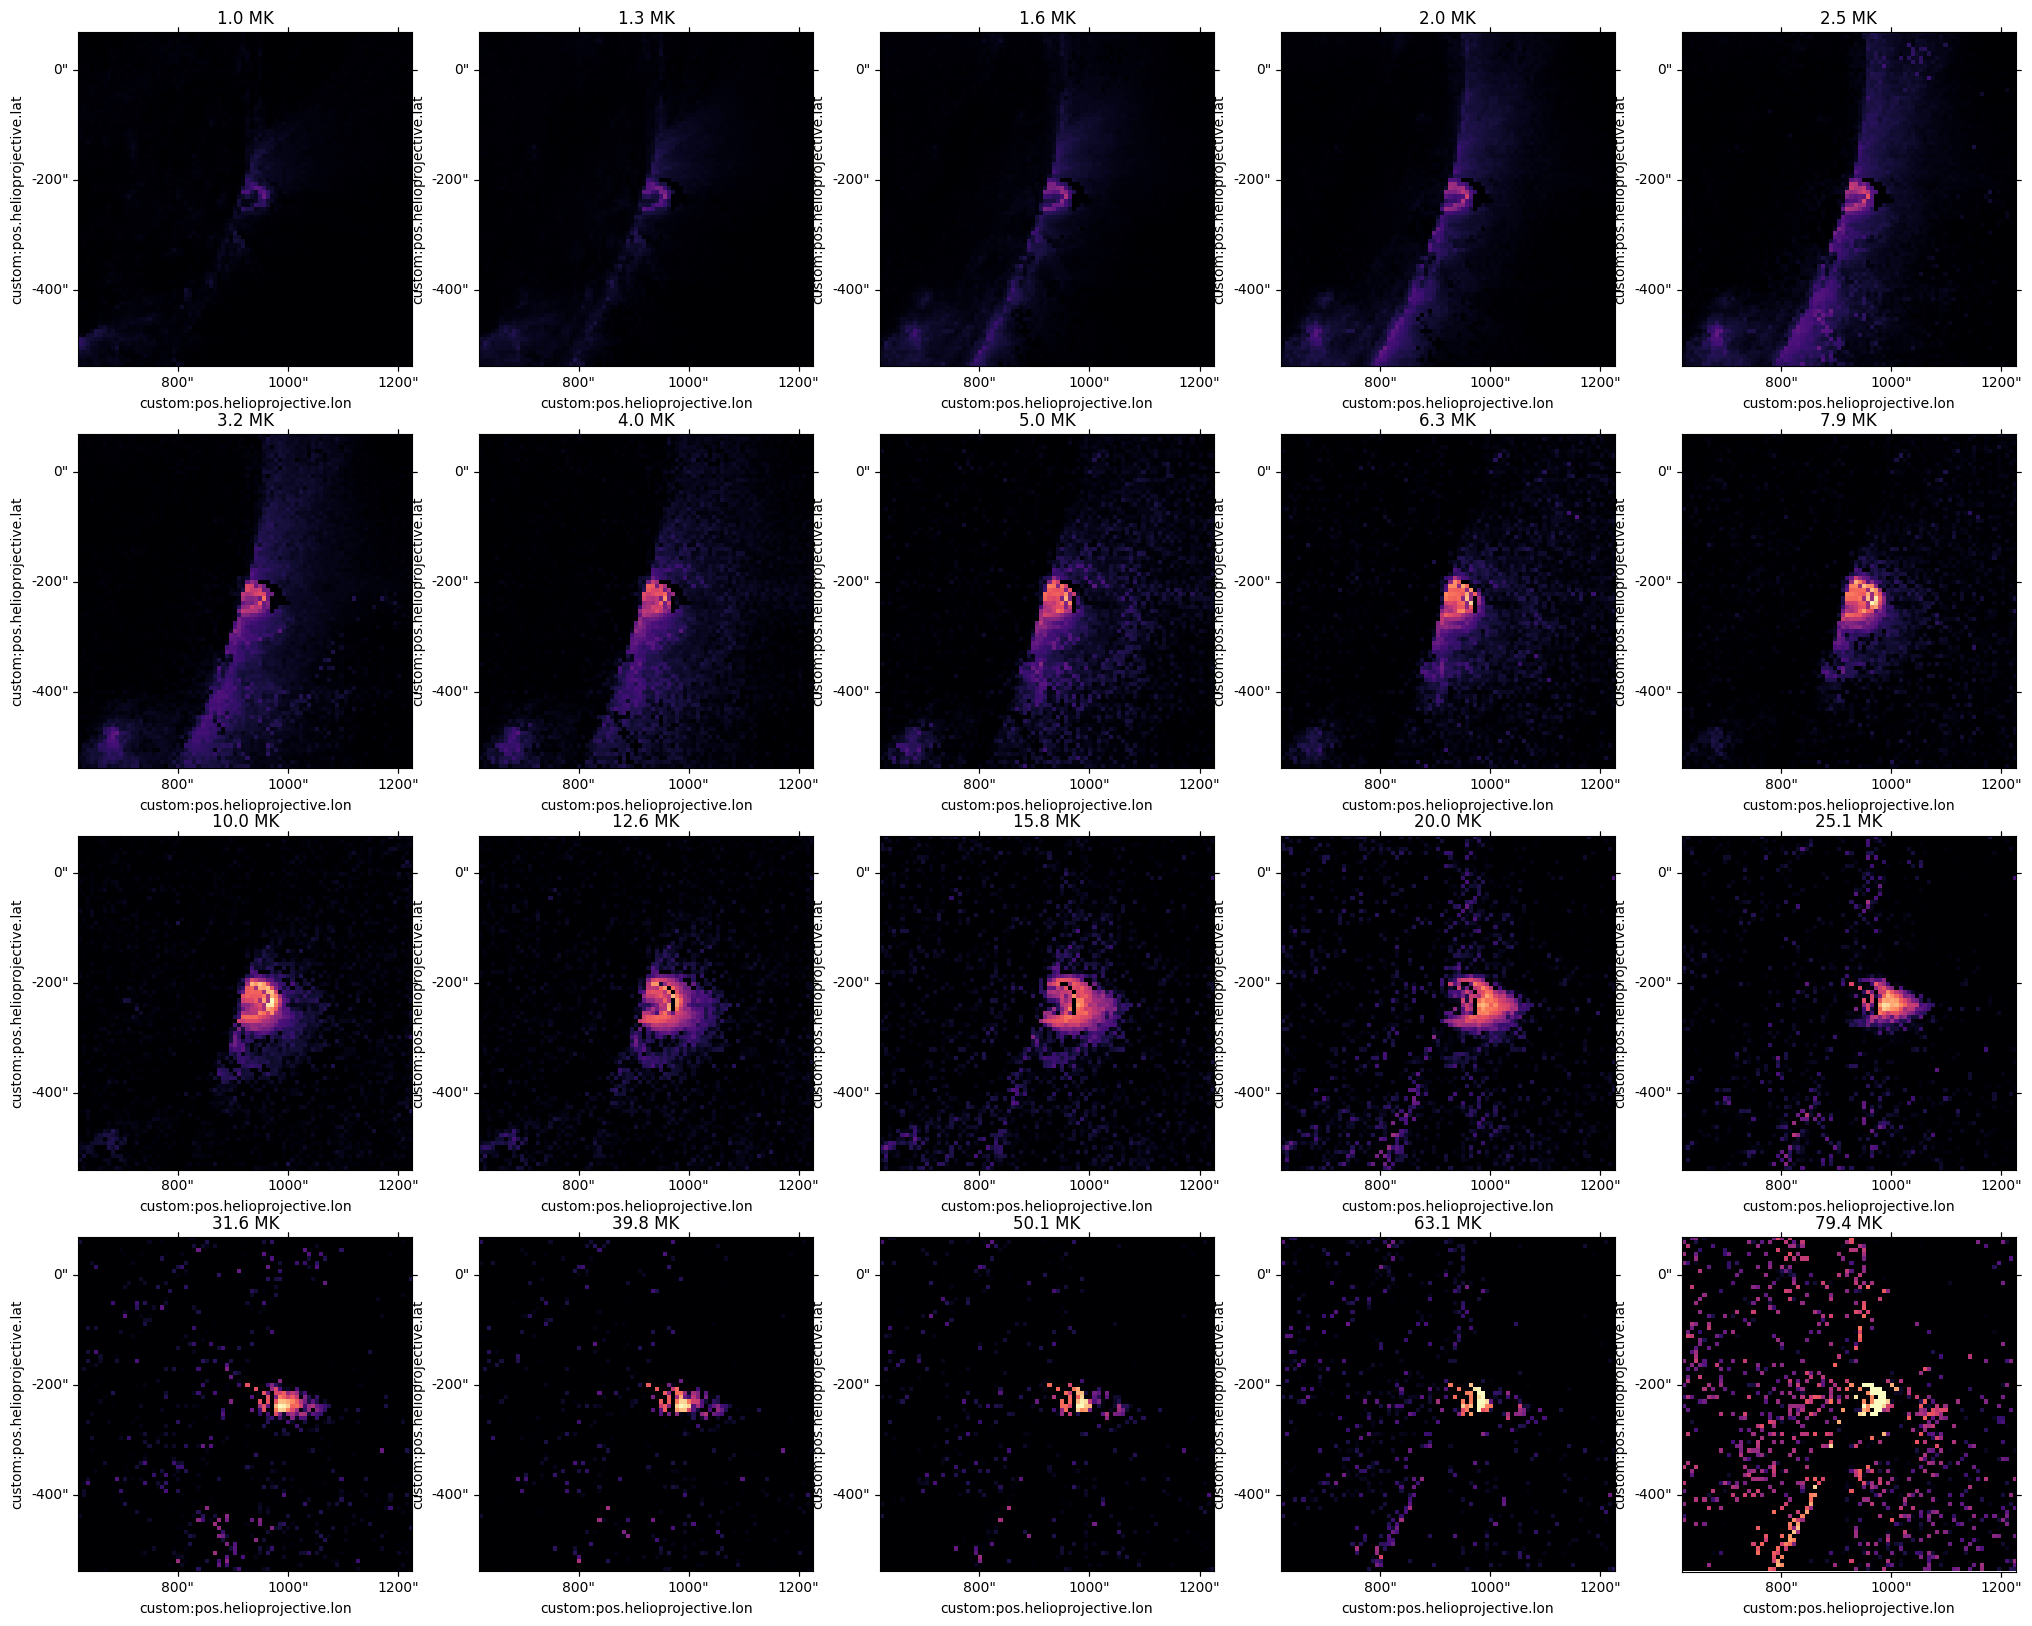

In [11]:
fig = plt.figure(figsize=(25,20))
for i,em_slice in enumerate(em_cube):
    #em_slice = em_cube[i]
    ax = fig.add_subplot(4,5,i+1,projection=em_slice.wcs)
    em_slice.plot(axes=ax,norm=ImageNormalize(vmin=1e25,vmax=1e30, stretch=LogStretch()),cmap='magma')
    ax.set_title(f"{em_cube.axis_world_coords(0)[0][i].to('MK'):.1f}")

In [11]:
write_cube_with_xarray(
    em_cube,
    'temperature',
    cropped_map.wcs,
    '/Users/wtbarnes/Documents/codes/mocksipipeline/pipeline/results/limb-flare/dem_cube.nc',
)

In [27]:
spec_cube = read_data_cube('/Users/wtbarnes/Documents/codes/mocksipipeline/pipeline/results/limb-flare/spectral_cube.fits')

In [66]:
spec_cube.meta

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   82                                                  
NAXIS2  =                   82                                                  
NAXIS3  =                 9090                                                  
WCSAXES =                    3                                                  
CRPIX1  =              -1031.5                                                  
CRPIX2  =                898.5                                                  
CDELT1  =  0.00016666666666667                                                  
CDELT2  =  0.00016666666666667                                                  
CUNIT1  = 'deg     '                                                            
CUNIT2  = 'deg     '        

<WCSAxes: >

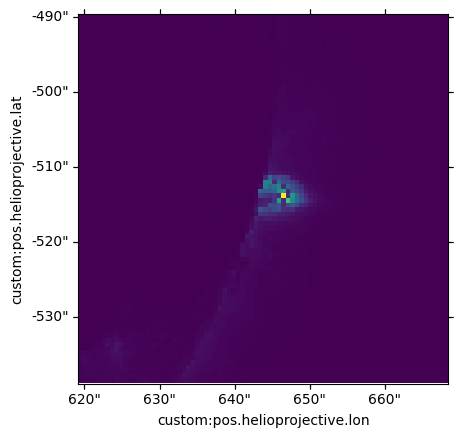

In [33]:
spec_cube.rebin((spec_cube.data.shape[0],1,1))[0].plot()

Now, let's visualize what the detector images from this flare look like

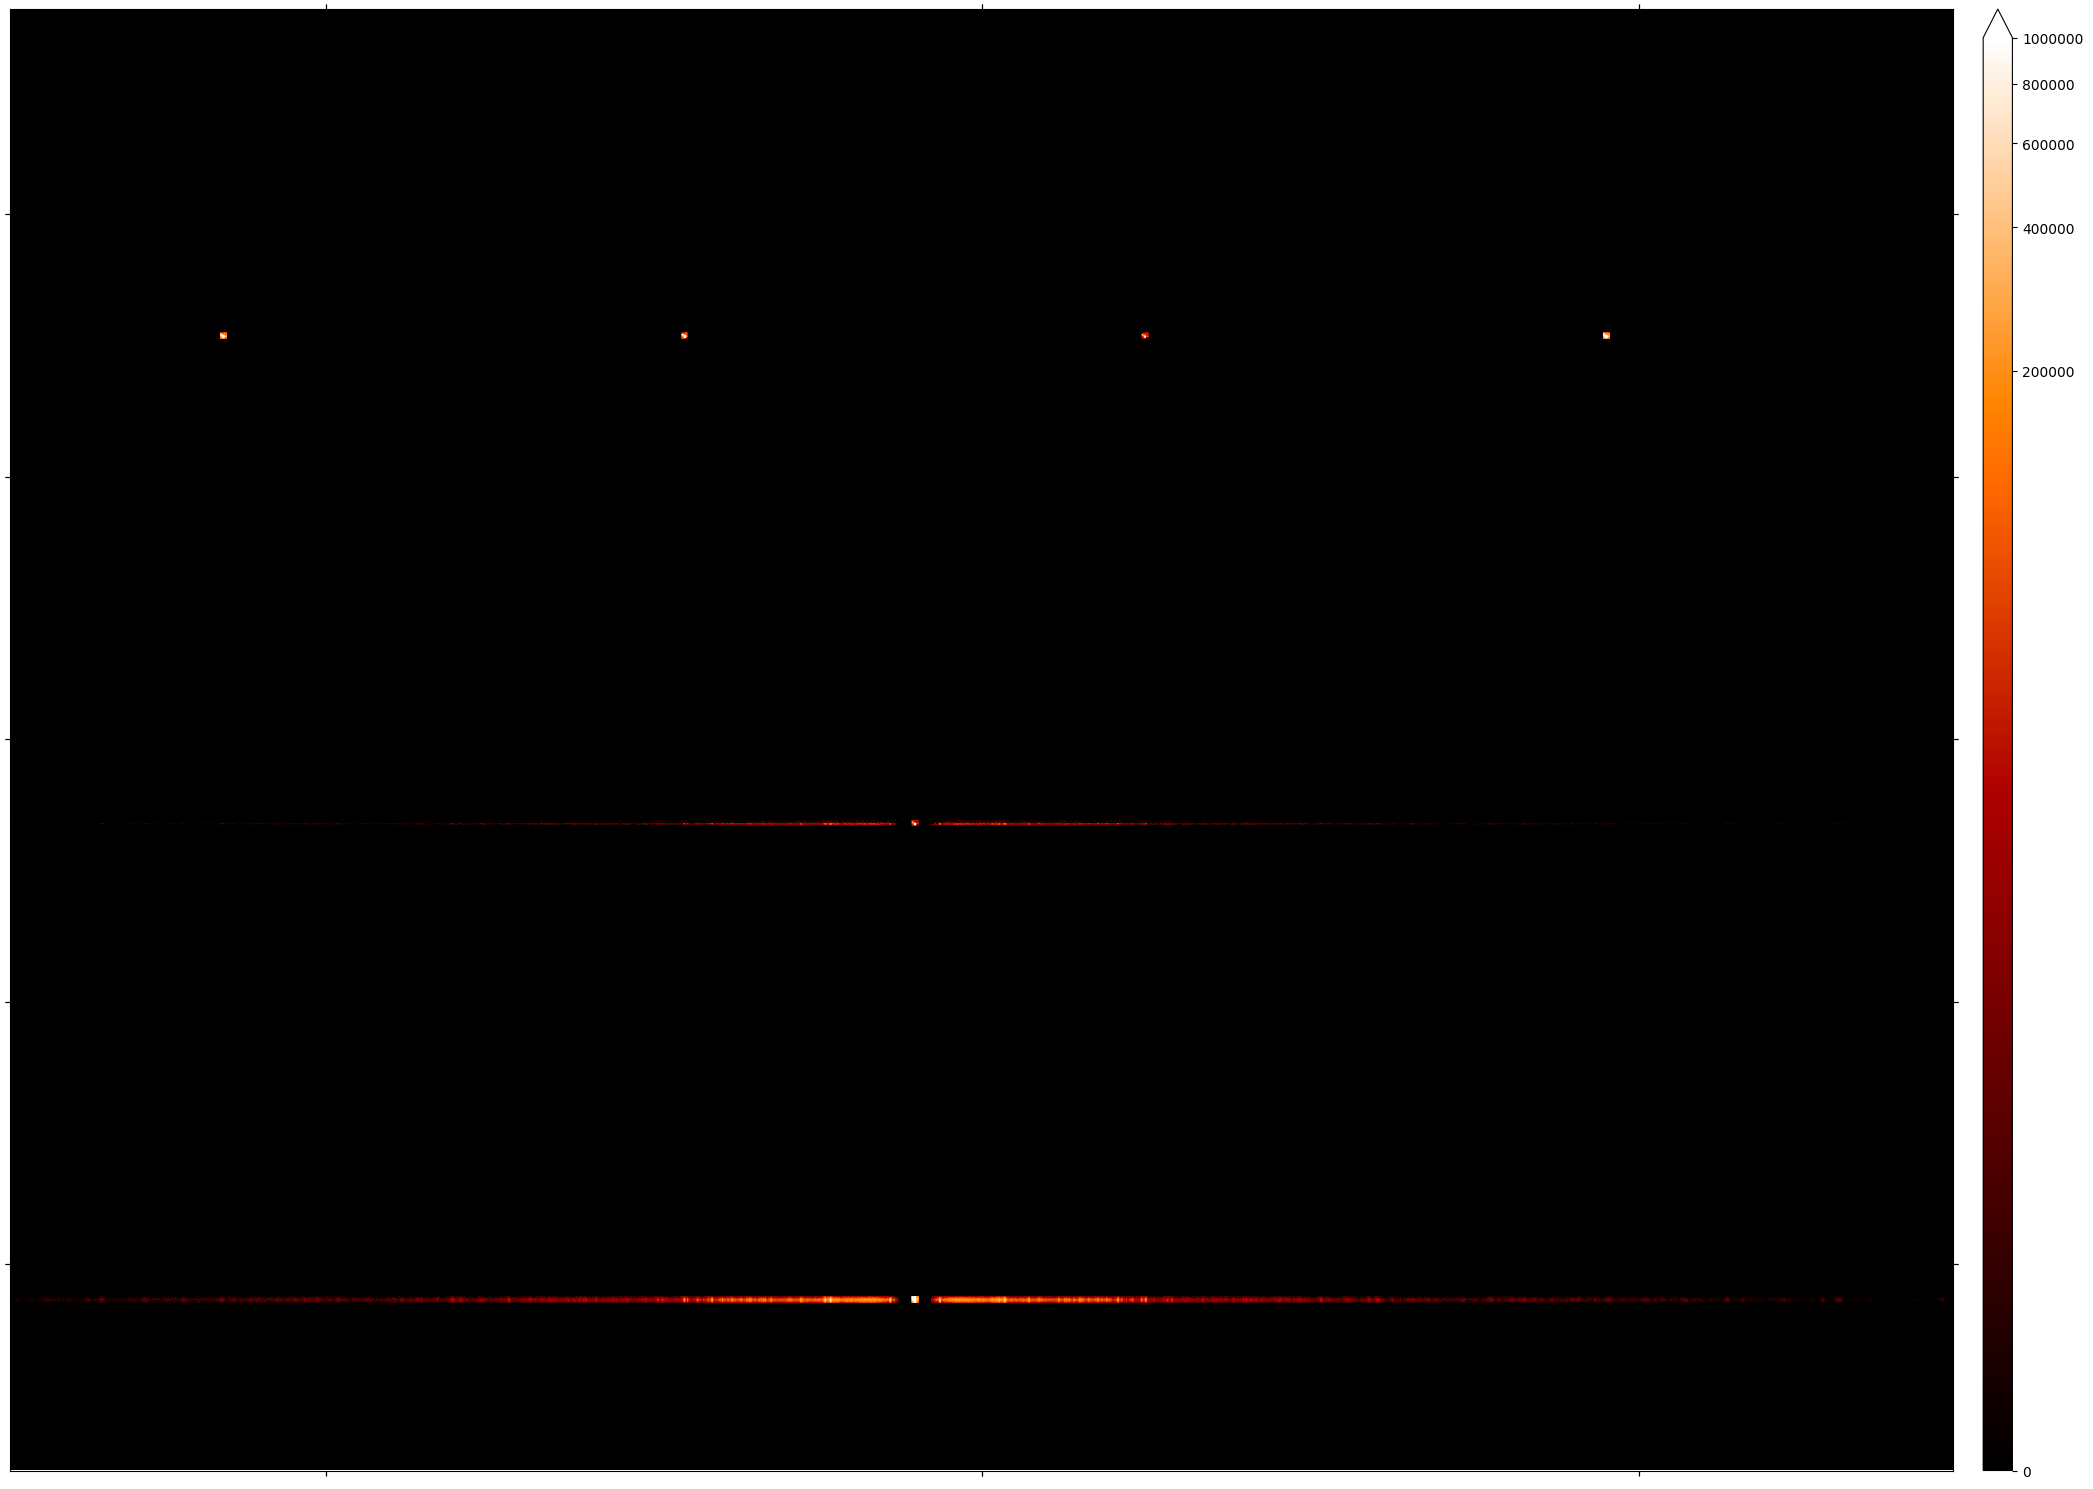

In [12]:
full_overlap_slot = read_overlappogram(
    '/Users/wtbarnes/Documents/codes/mocksipipeline/pipeline/results/limb-flare/detector_images/all_components.fits'
)#[:,500:1000,:]
fig = plt.figure(figsize=(30,30*.5),layout='tight')
ax = fig.add_subplot(projection=full_overlap_slot[0].wcs)
full_overlap_slot[0].plot(axes=ax,
                          cmap='hinodexrt',
                          interpolation='none',
                          norm=ImageNormalize(vmax=1e6,stretch=LogStretch()))
cbar_kwargs = {}
cbar_kwargs = {'extend':'max', 'extendfrac':0.02}
fig.colorbar(ax.get_images()[0], ax=ax, orientation='vertical', pad=0.01, aspect=50, **cbar_kwargs)

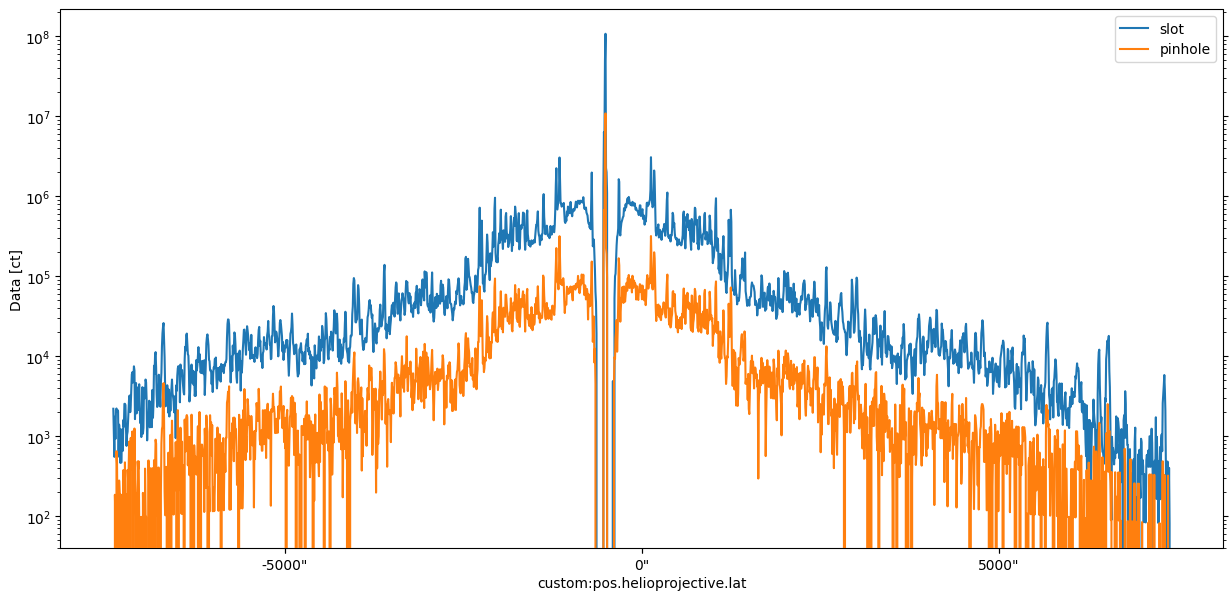

In [17]:
fig = plt.figure(figsize=(15,7))
ax = full_overlap_slot[0,:500,:].rebin((500,1), operation=np.sum)[0,:].plot(label='slot')
full_overlap_slot[0,500:1000,:].rebin((500,1), operation=np.sum)[0,:].plot(axes=ax,label='pinhole')
ax.set_yscale('log')
ax.legend()